In [1]:
import numpy as np
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
import torch
import matplotlib.pyplot as plt

In [2]:
rand_feature_map = torch.normal(0, 1, (10, 512, 512))

In [3]:
X = rand_feature_map.numpy().reshape(-1)
y = X >= 0
X = np.clip(X + np.random.normal(0, 1, X.shape), 0, 1)

X = X[:10_000]
y = y[:10_000]

In [4]:
lr = LogisticRegression()
lr.fit(X.reshape(-1, 1), y)

LogisticRegression()

In [5]:
ir = IsotonicRegression(out_of_bounds='clip')
ir.fit(X, y)

IsotonicRegression(out_of_bounds='clip')

In [6]:
class TorchLogisticRegression(torch.nn.Module):
    def __init__(self, lr: LogisticRegression):
        super().__init__()
        self._coef = torch.nn.Parameter(torch.from_numpy(lr.coef_))
        self._intercept = torch.nn.Parameter(torch.from_numpy(lr.intercept_))
    def forward(self, probs):
        return torch.sigmoid(probs*self._coef + self._intercept)

In [7]:
class TorchIsotonicRegression(torch.nn.Module):
    def __init__(self, ir: IsotonicRegression):
        super().__init__()
        self.x_vals = torch.nn.Parameter(torch.from_numpy(ir.f_.x), requires_grad=False)
        self.y_vals = torch.nn.Parameter(torch.from_numpy(ir.f_.y), requires_grad=False)
    def forward(self, inputs):
        masks = []
        for x_val, y_val in zip(self.x_vals, self.y_vals):
            masks.append(torch.where(inputs >= x_val, y_val, 0.))
        vals, _ = torch.max(torch.stack(masks, dim=0), dim=0)
        return vals 

In [8]:
torchLR = TorchLogisticRegression(lr)
torchIR = TorchIsotonicRegression(ir)

### LogisticRegression Test

In [ ]:
xs = rand_feature_map.numpy()
xs = xs.reshape(-1, 1)

In [ ]:
%%timeit
res = lr.predict_proba(xs)[:, 1]
res = res.reshape(rand_feature_map.shape)

In [ ]:
%%timeit
with torch.no_grad():
    res = torchLR.forward(rand_feature_map)
    _ = res.numpy()

In [ ]:
torchLR.to("cuda")
rand_feature_map = rand_feature_map.to("cuda")

In [ ]:
%%timeit
with torch.no_grad():
    res = torchLR.forward(rand_feature_map)
    _ = res.cpu().numpy()

#### Test Results

In [ ]:
torchLR.to("cpu")
rand_feature_map = rand_feature_map.to("cpu")
with torch.no_grad():
    torch_res = torchLR.forward(rand_feature_map)
    torch_res = torch_res.numpy()

In [ ]:
xs = rand_feature_map.numpy()
xs = xs.reshape(-1, 1)
sklearn_res = lr.predict_proba(xs)[:, 1]
sklearn_res = sklearn_res.reshape(rand_feature_map.shape)

In [ ]:
np.allclose(torch_res, sklearn_res)

### IsotonicRegression Test

In [ ]:
xs = rand_feature_map.numpy()
xs = xs.reshape(-1)

In [ ]:
%%timeit
res = ir.predict(xs)
res = res.reshape(rand_feature_map.shape)

In [ ]:
%%timeit
with torch.no_grad():
    res = torchIR.forward(rand_feature_map)
    _ = res.numpy()

In [ ]:
torchIR.to("cuda")
rand_feature_map = rand_feature_map.to("cuda")

In [ ]:
%%timeit
with torch.no_grad():
    res = torchIR.forward(rand_feature_map)
    _ = res.cpu().numpy()

#### Test Results

In [ ]:
torchIR.to("cpu")
rand_feature_map = rand_feature_map.to("cpu")
with torch.no_grad():
    torch_res = torchIR.forward(rand_feature_map)
    torch_res = torch_res.numpy()

In [ ]:
xs = rand_feature_map.numpy()
xs = xs.reshape(-1)
sklearn_res = ir.predict(xs)
sklearn_res = sklearn_res.reshape(rand_feature_map.shape)

In [ ]:
# formula: y = y1 + (x - x1)*slope

# slope[n] is for xs in interval x[n] - x[n+1]
# so formula is: y = y[n] + (x - x[n])*slopes[n]

In [ ]:
rand_feature_map = rand_feature_map.to("cpu")

In [9]:
x_vals = torch.nn.Parameter(torch.from_numpy(ir.f_.x), requires_grad=False)
y_vals = torch.nn.Parameter(torch.from_numpy(ir.f_.y), requires_grad=False)
slopes = torch.nn.Parameter(
    torch.from_numpy(
        np.concatenate([
            (ir.f_.y[1:] - ir.f_.y[:-1]) / (ir.f_.x[1:] - ir.f_.x[:-1]),
            np.array([0.]),
        ])
))
masks = []
for x_val, y_val in zip(x_vals, y_vals):
    masks.append(torch.where(rand_feature_map >= x_val, x_val, 0.))
_, ind = torch.max(torch.stack(masks, dim=0), dim=0)
y = y_vals[ind] + (rand_feature_map - x_vals[ind])*slopes[ind]

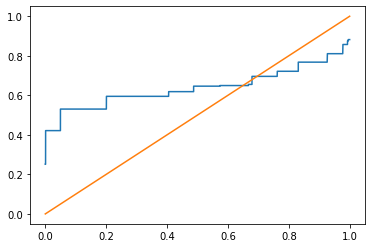

In [12]:
plt.plot(x_vals, y_vals)
plt.plot(np.array([0, 1]), np.array([0, 1]))

In [ ]:
i, j, k = 0, 0, 1

In [ ]:
x_vals

In [ ]:
y_vals

In [ ]:
def find():
    for i in range(3):
        for j in range(512):
            for k in range(512):
                if not np.allclose(y[i, j, k].detach().numpy(), ir.f_(rand_feature_map[i, j, k])):
                    print(i, j, k)
                    return

find()

In [ ]:
y[i, j, k].detach().numpy(), ir.f_(rand_feature_map[i, j, k])

In [ ]:
ind[i, j, k]

In [ ]:
slopes[ind[i, j, k]]

In [ ]:
x_vals[ind[i, j, k]]

In [ ]:
y_vals[ind[i, j, k]]

In [ ]:
(rand_feature_map[i, j, k] - x_vals[ind[i, j, k]])

In [ ]:
ind[i, j, k], rand_feature_map[i, j, k]

In [ ]:
from itertools import zip_longest

In [ ]:
list(zip_longest(range(ind[i, j, k]-3, ind[i, j, k]+3), x_vals[ind[i, j, k]-3:ind[i, j, k]+3]))

In [ ]:
list(zip_longest(range(ind[i, j, k]-3, ind[i, j, k]+3), y_vals[ind[i, j, k]-3:ind[i, j, k]+3]))

In [ ]:
list(zip(zip_longest(ind[i, j, k]-3, ind[i, j, k]+3), slopes[ind[i, j, k]-3:ind[i, j, k]+3]))